In [5]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm
import os, copy, argparse, configparser
import sys, datetime, csv, random
from tqdm import tqdm
from torchmetrics import PeakSignalNoiseRatio
import pytorch_lightning as pl
from torchvision.utils import save_image
import network_models as models
import function_losses as losses
# import pytorch_model_summary as mosum
from PIL import Image

# ======================================================================
# take options 
# ======================================================================
parser = argparse.ArgumentParser()
parser.add_argument("--dir_work", type=str, default='/nas/users/minhyeok/energy_based_model')
parser.add_argument("--device_cuda", type=int, default=0)

parser.add_argument("--model_conv", type=str, default='conv_double_resnet')
parser.add_argument("--model_activation", type=str, default='leakyrelu')
parser.add_argument("--model_output", type=str, default='tanh')
parser.add_argument("--model_use_batch_norm", type=eval, default=False, choices=[True, False])
parser.add_argument("--model_use_skip", type=eval, default=False, choices=[True, False])
parser.add_argument("--model_use_dual_input", type=eval, default=True, choices=[True, False])
parser.add_argument("--model_dim_feature", type=int, default=16)
parser.add_argument("--model_dim_latent", type=int, default=100)

parser.add_argument("--data_name", type=str, default='CIFAR10')
parser.add_argument("--data_use_all", type=eval, default=False, choices=[True, False])
parser.add_argument("--data_label_subset", type=int, default=5)
parser.add_argument("--data_channel", type=int, default=3)
parser.add_argument("--image_size", type=int, default=32)
parser.add_argument("--data_noise_sigma", type=float, default=0.15)

parser.add_argument("--optim_option", type=str, default='adam')
parser.add_argument("--optim_length_epoch", type=int, default=500)
parser.add_argument("--optim_size_batch", type=int, default=100)
parser.add_argument("--optim_lr_model", type=float, default=0.0005)
parser.add_argument("--optim_lr_energy", type=float, default=0.0005)
parser.add_argument("--optim_lr_data", type=float, default=0.0001)
parser.add_argument("--optim_lr_langevin", type=float, default=0.00005)
parser.add_argument("--optim_length_langevin", type=int, default=50)
parser.add_argument("--optim_weight_gradient", type=float, default=0.0001)
parser.add_argument("--optim_weight_regular", type=float, default=0.0001)

parser.add_argument("--save_point", type=int, default=100, help='number of iterations of between saving')
parser.add_argument("--figure_plot", type=int, default=50)

args = parser.parse_args(args=[])

# ======================================================================
# assign options
# ======================================================================
dir_work                = args.dir_work
device_cuda             = args.device_cuda

model_conv              = args.model_conv
model_activation        = args.model_activation
model_output            = args.model_output
model_use_batch_norm    = args.model_use_batch_norm
model_use_skip          = args.model_use_skip
model_use_dual_input    = args.model_use_dual_input
model_dim_feature       = args.model_dim_feature
model_dim_latent        = args.model_dim_latent

data_name               = args.data_name.upper()
data_use_all            = args.data_use_all
data_label_subset       = args.data_label_subset 
data_channel            = args.data_channel
img_size                = args.image_size
data_noise_sigma        = args.data_noise_sigma

optim_option            = args.optim_option
optim_length_epoch      = args.optim_length_epoch
optim_size_batch        = args.optim_size_batch
optim_lr_model          = args.optim_lr_model
optim_lr_energy         = args.optim_lr_energy
optim_lr_data           = args.optim_lr_data
optim_lr_langevin       = args.optim_lr_langevin
optim_length_langevin   = args.optim_length_langevin
optim_weight_gradient   = args.optim_weight_gradient
optim_weight_regular    = args.optim_weight_regular

# ======================================================================
# path for the results
# ======================================================================
now         = datetime.datetime.now()
date_stamp  = now.strftime('%Y_%m_%d') 
time_stamp  = now.strftime('%H_%M_%S') 

dir_figure  = os.path.join(dir_work, 'figure')
dir_option  = os.path.join(dir_work, 'option')
dir_result  = os.path.join(dir_work, 'result')
dir_model   = os.path.join(dir_work, 'model')

path_figure = os.path.join(dir_figure, data_name)
path_option = os.path.join(dir_option, data_name)
path_result = os.path.join(dir_result, data_name)
path_model  = os.path.join(dir_model, data_name)

date_figure = os.path.join(path_figure, date_stamp)
date_option = os.path.join(path_option, date_stamp)
date_result = os.path.join(path_result, date_stamp)
date_model  = os.path.join(path_model, date_stamp)

file_figure = os.path.join(date_figure, '{}.png'.format(time_stamp))
file_option = os.path.join(date_option, '{}.ini'.format(time_stamp))
file_result = os.path.join(date_result, '{}.csv'.format(time_stamp))
file_model  = os.path.join(date_model, '{}.pth'.format(time_stamp))

if not os.path.exists(dir_figure):
    os.mkdir(dir_figure)
if not os.path.exists(dir_option):
    os.mkdir(dir_option)
if not os.path.exists(dir_result):
    os.mkdir(dir_result)
if not os.path.exists(dir_model):
    os.mkdir(dir_model)
if not os.path.exists(path_figure):
    os.mkdir(path_figure)
if not os.path.exists(path_option):
    os.mkdir(path_option)
if not os.path.exists(path_result):
    os.mkdir(path_result)
if not os.path.exists(path_model):
    os.mkdir(path_model)
if not os.path.exists(date_figure):
    os.mkdir(date_figure)
if not os.path.exists(date_option):
    os.mkdir(date_option)
if not os.path.exists(date_result):
    os.mkdir(date_result)
if not os.path.exists(date_model):
    os.mkdir(date_model)

device = torch.device(f'cuda:{device_cuda}' if torch.cuda.is_available() else 'mps')

# ======================================================================
# random seed
# ======================================================================
pl.seed_everything(0)

# ======================================================================
# dataset 
# ======================================================================
dir_data = '/hdd1/dataset'

transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize(img_size),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Lambda(lambda t: (t - torch.mean(t)) / torch.std(t)) # mean 0, std 1
    # torchvision.transforms.Lambda(lambda t: 2.0 * t - 1) 
])

# the name of the dataset is used as upper case
if data_name == 'MNIST':
    dataset         = torchvision.datasets.MNIST(dir_data, transform=transform, train=True, download=True)
    dataset_test    = torchvision.datasets.MNIST(dir_data, transform=transform, train=False, download=True)

elif data_name == 'CIFAR10':
    dataset                 = torchvision.datasets.CIFAR10(f'{dir_data}/CIFAR', transform=transform, train=True, download=False)
    dataset.data            = np.array(dataset.data)
    dataset.targets         = np.array(dataset.targets)
    dataset_test            = torchvision.datasets.CIFAR10(f'{dir_data}/CIFAR', transform=transform, train=False, download=False)
    dataset_test.data       = np.array(dataset_test.data)
    dataset_test.targets    = np.array(dataset_test.targets)

elif data_name == 'CELEBA':
    dataset = torchvision.datasets.CelebA(f'{dir_data}/celeba', transform=transform, download=False)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    dataset, dataset_test = torch.utils.data.random_split(dataset, [train_size, test_size])
   
if data_name == 'MNIST' or data_name == 'CIFAR10': 
    if not data_use_all:
        idx_label               = (dataset.targets==data_label_subset)
        dataset.data            = dataset.data[idx_label]
        dataset.targets         = dataset.targets[idx_label]
        
        idx_label               = (dataset_test.targets==data_label_subset)
        dataset_test.data       = dataset_test.data[idx_label]
        dataset_test.targets    = dataset_test.targets[idx_label]

    num_data_real       = len(dataset)
    number_data_real    = 5000
    dataset.data        = dataset.data[0:number_data_real]
    dataset.targets     = dataset.targets[0:number_data_real]

dataloader      = torch.utils.data.DataLoader(dataset=dataset, batch_size=optim_size_batch*2, drop_last=True, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=optim_size_batch, drop_last=True, shuffle=True)


# ======================================================================
# model
# ======================================================================
model = models.auto_encoder2(
            dim_channel=data_channel,
            dim_feature=model_dim_feature,
            dim_latent=model_dim_latent,
            use_batch_norm=model_use_batch_norm, 
            activation_output=model_output).to(device)

energy = models.energy(
            dim_channel=data_channel,
            dim_feature=model_dim_feature,
            dim_latent=model_dim_latent,
            use_batch_norm=False,
            use_dual_input=model_use_dual_input).to(device)


if optim_option.lower() == 'sgd':
    optim_model     = torch.optim.SGD(model.parameters(), lr=optim_lr_model)
    optim_energy    = torch.optim.SGD(energy.parameters(), lr=optim_lr_energy)
elif optim_option.lower() == 'adam':
    optim_model     = torch.optim.Adam(model.parameters(), lr=optim_lr_model)
    optim_energy    = torch.optim.Adam(energy.parameters(), lr=optim_lr_energy)
elif optim_option.lower() == 'adamw':
    optim_model     = torch.optim.AdamW(model.parameters(), lr=optim_lr_model)
    optim_energy    = torch.optim.AdamW(energy.parameters(), lr=optim_lr_energy)


scheduler_model     = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_model, factor=0.0001, patience=10, mode='min')
scheduler_energy    = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_energy, factor=0.0001, patience=10, mode='min')

# ======================================================================
# evaluation 
# ======================================================================
psnr = PeakSignalNoiseRatio().to(device)

# ======================================================================
# training 
# ======================================================================
val_loss_model_mean     = np.zeros(optim_length_epoch)
val_loss_model_std      = np.zeros(optim_length_epoch)
val_loss_energy_mean    = np.zeros(optim_length_epoch)
val_loss_energy_std     = np.zeros(optim_length_epoch)
val_psnr_mean           = np.zeros(optim_length_epoch)
val_psnr_std            = np.zeros(optim_length_epoch)
val_psnr_update_mean    = np.zeros(optim_length_epoch)
val_psnr_update_std     = np.zeros(optim_length_epoch)

Global seed set to 0


In [6]:
model.train()
energy.train()
sigma_np = np.logspace(0, np.log10(data_noise_sigma), optim_size_batch)
sigma = torch.Tensor(sigma_np).view((optim_size_batch,1,1,1)).to(device)

for i in range(optim_length_epoch):
    val_loss_model  = []
    val_loss_energy = []
    val_psnr        = []
    val_psnr_update = []

    for j, (image, _) in enumerate(dataloader):
        data, real  = torch.split(image, optim_size_batch, dim=0)
        
        noise       = torch.randn_like(data)
        data_noise  = data + data_noise_sigma * noise
        
        noise       = torch.randn_like(data)
        real_noise  = real + data_noise_sigma * noise
     
        data        = data.to(device) 
        real        = real.to(device) 
        data_noise  = data_noise.to(device)
        real_noise  = real_noise.to(device)
        
        # -------------------------------------------------------------------
        # predictions
        # -------------------------------------------------------------------         
        model.eval()
        pred, mu, log_var, z = model(data_noise)
        pred_noise = pred.detach().cpu() + data_noise_sigma * noise
        pred_noise = pred_noise.to(device)
        
        # -------------------------------------------------------------------
        # interpolation
        # -------------------------------------------------------------------         
        alpha   = torch.rand(optim_size_batch, 1, 1, 1)
        alpha   = alpha.expand_as(real).to(device)
        interp  = alpha * real.data + (1 - alpha) * pred.data
        interp  = Parameter(interp, requires_grad=True)

        energy.eval()
        # -------------------------------------------------------------------
        # predictions
        # -------------------------------------------------------------------
        if model_use_dual_input:
            energy_positive = energy(real, real)        
            energy_negative = energy(pred_noise, pred)        
            energy_interp   = energy(interp, interp)
        else:
            energy_positive = energy(real)        
            energy_negative = energy(pred)        
            energy_interp   = energy(interp)
        
        # -------------------------------------------------------------------
        # update energy model 
        # -------------------------------------------------------------------         
        energy.train()
        optim_energy.zero_grad()
        loss_positive   = energy.compute_loss_positive(energy_negative, energy_positive)
        loss_gradient   = losses.compute_gradient_penalty(interp, energy_interp)
        loss_energy     = loss_positive + optim_weight_gradient * loss_gradient
        loss_energy.backward()
        optim_energy.step()
        scheduler_energy.step(loss_energy)
        
        # -------------------------------------------------------------------
        # update input fake 
        # -------------------------------------------------------------------
        energy.eval()
        pred_update = Parameter(pred, requires_grad=True) 
        
        for k in range(optim_length_langevin): 

            if model_use_dual_input:
                energy_negative = energy(pred_update, pred_update)
            else:
                energy_negative = energy(pred_update)
            
            loss_negative = energy.compute_loss_negative(energy_negative)
            loss_negative.backward()
            noise = torch.randn_like(pred_update.data)    # N(mean=0, std=1)
            pred_update.data = pred_update.data - optim_lr_data * pred_update.grad + optim_lr_langevin * noise * data_noise_sigma
            pred_update.grad.detach_()
            pred_update.grad.zero_() 

        # -------------------------------------------------------------------
        # update model 
        # -------------------------------------------------------------------         
        optim_model.zero_grad()
        pred, mu, log_var, z = model(data_noise)
        model.train()
        loss_model, loss_data, loss_regular = model.compute_loss(pred, pred_update, mu, log_var, optim_weight_regular) 
        loss_model.backward()
        optim_model.step()        
        scheduler_model.step(loss_model)

        value_psnr          = psnr(pred.data, data).detach().cpu().numpy().mean()
        value_psnr_update   = psnr(pred_update.data, data).detach().cpu().numpy().mean()
        
        val_loss_model.append(loss_model.item()) 
        val_loss_energy.append(loss_energy.item()) 
        val_psnr.append(value_psnr)
        val_psnr_update.append(value_psnr_update)
    
    # if i % 10 == 0:
    #     dir_log             = os.path.join(dir_work, 'log')
    #     file_pred           = os.path.join(dir_log, 'image/pred.png')
    #     file_pred_update    = os.path.join(dir_log, 'image/pred_update.png')
    #     file_pred           = os.path.join(dir_log, 'image/{:03d}.png'.format(i))
    #     file_pred_update    = os.path.join(dir_log, 'image/{:03d}_update.png'.format(i))
        
    #     save_image(pred.data[:25], file_pred, nrow=5, normalize=True)
    #     save_image(pred_update.data[:25], file_pred_update, nrow=5, normalize=True)
        
    
    val_loss_model_mean[i]  = np.mean(val_loss_model)
    val_loss_model_std[i]   = np.std(val_loss_model)
    val_loss_energy_mean[i] = np.mean(val_loss_energy)
    val_loss_energy_std[i]  = np.std(val_loss_energy)
    val_psnr_mean[i]        = np.mean(val_psnr)
    val_psnr_std[i]         = np.std(val_psnr)
    val_psnr_update_mean[i] = np.mean(val_psnr_update)
    val_psnr_update_std[i]  = np.std(val_psnr_update)

    log = '[%4d/%4d] loss(model)=%8.7f, loss(energy)=%8.7f, psnr=%4.2f, psnr(update)=%4.2f' % (i, optim_length_epoch, 
                        val_loss_model_mean[i], val_loss_energy_mean[i], val_psnr_mean[i], val_psnr_update_mean[i])
    print(log, flush=True)
    
    if np.isnan(val_loss_model_mean[i]) or np.isnan(val_loss_energy_mean[i]) or val_psnr_mean[i] < 3:
        sys.exit('error')

    if i % args.save_point == 0:
# -------------------------------------------------------------------
# save the models
# -------------------------------------------------------------------          
        torch.save({
            'state_dict_model'      : model.state_dict(),
            'state_dict_energy'     : energy.state_dict(),
            'model_conv'            : model_conv,
            'model_activation'      : model_activation,
            'model_output'          : model_output,
            'model_use_batch_norm'  : model_use_batch_norm,
            'model_use_skip'        : model_use_skip,
            'model_use_dual_input'  : model_use_dual_input,
            'model_dim_feature'     : model_dim_feature,
            'model_dim_latent'      : model_dim_latent,
            'data_name'             : data_name,
            'data_use_all'          : data_use_all,
            'data_label_subset'     : data_label_subset,
            'data_channel'          : data_channel,
            'data_size  '           : img_size,
            'data_noise_sigma'      : data_noise_sigma,
            'optim_option'          : optim_option,
            'optim_length_epoch'    : optim_length_epoch,
            'optim_size_batch'      : optim_size_batch,
            'optim_lr_model'        : optim_lr_model,
            'optim_lr_energy'       : optim_lr_energy,
            'optim_lr_data'         : optim_lr_data,
            'optim_lr_langevin'     : optim_lr_langevin,
            'optim_length_langevin' : optim_length_langevin,
            'optim_weight_gradient' : optim_weight_gradient,
            'optim_weight_regular'  : optim_weight_regular,
        }, file_model)

    if i % args.figure_plot == 0 and i != 0:
        nnow = datetime.datetime.now().strftime('%H_%M_%S')
        
        data_tmp        = data.detach().cpu().numpy().squeeze()
        data_noise_tmp  = data_noise.detach().cpu().numpy().squeeze()
        pred_tmp        = pred.detach().cpu().numpy().squeeze()
        pred_update_tmp = pred_update.detach().cpu().numpy().squeeze()
        
        fig, ax = plt.subplots(4, 5, figsize=(3 * 5, 3 * 4))
        
        for k in range(5):
            ax[0][k].set_title('clean')
            ax[0][k].imshow(np.transpose(data_tmp[k], (1,2,0)))
            
        for k in range(5):
            ax[1][k].set_title('noisy')
            ax[1][k].imshow(np.transpose(data_noise_tmp[k],(1,2,0)))

        for k in range(5):
            ax[2][k].set_title('y_0')
            ax[2][k].imshow(np.transpose(pred_tmp[k],(1,2,0)))

        for k in range(5):
            ax[3][k].set_title('y_n')
            ax[3][k].imshow(np.transpose(pred_update_tmp[k],(1,2,0)))

        plt.tight_layout()
        fig.savefig(f'{date_figure}/log_{i}_{nnow}.png', bbox_inches='tight', dpi=300)
        plt.close(fig)
        
        del data_tmp, data_noise_tmp, pred_tmp, pred_update_tmp
# -------------------------------------------------------------------
# save the options
# -------------------------------------------------------------------         
with open(file_option, 'w') as f:
    f.write('{}: {}\n'.format('model_conv', model_conv))
    f.write('{}: {}\n'.format('model_activation', model_activation))
    f.write('{}: {}\n'.format('model_output', model_output))
    f.write('{}: {}\n'.format('model_use_batch_norm', model_use_batch_norm))
    f.write('{}: {}\n'.format('model_use_skip', model_use_skip))
    f.write('{}: {}\n'.format('model_use_dual_input', model_use_dual_input))
    f.write('{}: {}\n'.format('model_dim_feature', model_dim_feature))
    f.write('{}: {}\n'.format('model_dim_latent', model_dim_latent))
    f.write('{}: {}\n'.format('data_name', data_name))
    f.write('{}: {}\n'.format('data_use_all', data_use_all))
    f.write('{}: {}\n'.format('data_label_subset', data_label_subset))
    f.write('{}: {}\n'.format('data_channel', data_channel))
    f.write('{}: {}\n'.format('image_size', img_size))
    f.write('{}: {}\n'.format('data_noise_sigma', data_noise_sigma))
    f.write('{}: {}\n'.format('optim_option', optim_option))
    f.write('{}: {}\n'.format('optim_length_epoch', optim_length_epoch))
    f.write('{}: {}\n'.format('optim_size_batch', optim_size_batch))
    f.write('{}: {}\n'.format('optim_lr_model', optim_lr_model))
    f.write('{}: {}\n'.format('optim_lr_energy', optim_lr_energy))
    f.write('{}: {}\n'.format('optim_lr_data', optim_lr_data))
    f.write('{}: {}\n'.format('optim_lr_langevin', optim_lr_langevin))
    f.write('{}: {}\n'.format('optim_length_langevin', optim_length_langevin))
    f.write('{}: {}\n'.format('optim_weight_gradient', optim_weight_gradient))
    f.write('{}: {}\n'.format('optim_weight_regular', optim_weight_regular))
f.close()
    
# -------------------------------------------------------------------
# save training results
# -------------------------------------------------------------------         
data        = data.detach().cpu().numpy().squeeze()
data_noise  = data_noise.detach().cpu().numpy().squeeze()
pred        = pred.detach().cpu().numpy().squeeze()
pred_update = pred_update.detach().cpu().numpy().squeeze()


[   0/ 500] loss(model)=0.0002062, loss(energy)=-7836.1286608, psnr=5.96, psnr(update)=5.96
[   1/ 500] loss(model)=0.0031854, loss(energy)=-978869.9468750, psnr=5.99, psnr(update)=6.28
[   2/ 500] loss(model)=0.0154783, loss(energy)=-87685.1800000, psnr=8.89, psnr(update)=9.38
[   3/ 500] loss(model)=0.0161827, loss(energy)=7029.8900000, psnr=9.07, psnr(update)=9.50
[   4/ 500] loss(model)=0.0161244, loss(energy)=929.8175000, psnr=9.11, psnr(update)=9.56
[   5/ 500] loss(model)=0.0161591, loss(energy)=1451.5775000, psnr=9.07, psnr(update)=9.52
[   6/ 500] loss(model)=0.0156697, loss(energy)=-9426.9475000, psnr=9.07, psnr(update)=9.51
[   7/ 500] loss(model)=0.0164975, loss(energy)=17633.7000000, psnr=9.03, psnr(update)=9.49
[   8/ 500] loss(model)=0.0160521, loss(energy)=10209.4825000, psnr=9.03, psnr(update)=9.49
[   9/ 500] loss(model)=0.0164511, loss(energy)=8265.9875000, psnr=9.05, psnr(update)=9.49
[  10/ 500] loss(model)=0.0162671, loss(energy)=12852.4275000, psnr=9.01, psnr(upd

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[  51/ 500] loss(model)=0.0163381, loss(energy)=-12726.6700000, psnr=9.09, psnr(update)=9.56
[  52/ 500] loss(model)=0.0160613, loss(energy)=-9480.0925000, psnr=9.10, psnr(update)=9.53
[  53/ 500] loss(model)=0.0162150, loss(energy)=2313.0075000, psnr=9.06, psnr(update)=9.53
[  54/ 500] loss(model)=0.0163890, loss(energy)=9499.0900000, psnr=9.05, psnr(update)=9.50
[  55/ 500] loss(model)=0.0160837, loss(energy)=-1517.9975000, psnr=9.06, psnr(update)=9.49
[  56/ 500] loss(model)=0.0161591, loss(energy)=-7326.4050000, psnr=9.08, psnr(update)=9.52
[  57/ 500] loss(model)=0.0159223, loss(energy)=11855.8100000, psnr=9.04, psnr(update)=9.49
[  58/ 500] loss(model)=0.0158675, loss(energy)=4179.4525000, psnr=9.04, psnr(update)=9.49
[  59/ 500] loss(model)=0.0160135, loss(energy)=4959.3700000, psnr=9.09, psnr(update)=9.54
[  60/ 500] loss(model)=0.0161256, loss(energy)=-3629.6400000, psnr=9.05, psnr(update)=9.47
[  61/ 500] loss(model)=0.0157339, loss(energy)=-5392.2900000, psnr=9.08, psnr(upda

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[ 101/ 500] loss(model)=0.0155445, loss(energy)=-6325.0875000, psnr=9.03, psnr(update)=9.46
[ 102/ 500] loss(model)=0.0164017, loss(energy)=-1106.4775000, psnr=9.03, psnr(update)=9.49
[ 103/ 500] loss(model)=0.0165316, loss(energy)=9968.9150000, psnr=9.04, psnr(update)=9.50
[ 104/ 500] loss(model)=0.0166981, loss(energy)=6179.3875000, psnr=9.02, psnr(update)=9.48
[ 105/ 500] loss(model)=0.0159574, loss(energy)=3123.4700000, psnr=9.04, psnr(update)=9.48
[ 106/ 500] loss(model)=0.0165614, loss(energy)=-2823.9925000, psnr=9.06, psnr(update)=9.51
[ 107/ 500] loss(model)=0.0165083, loss(energy)=-2862.2775000, psnr=9.06, psnr(update)=9.51
[ 108/ 500] loss(model)=0.0158514, loss(energy)=-6496.3525000, psnr=9.05, psnr(update)=9.49
[ 109/ 500] loss(model)=0.0161334, loss(energy)=2735.8550000, psnr=8.99, psnr(update)=9.43
[ 110/ 500] loss(model)=0.0156827, loss(energy)=-7601.5050000, psnr=9.09, psnr(update)=9.51
[ 111/ 500] loss(model)=0.0159946, loss(energy)=7311.5150000, psnr=8.99, psnr(update

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[ 151/ 500] loss(model)=0.0161983, loss(energy)=5327.1675000, psnr=9.07, psnr(update)=9.51
[ 152/ 500] loss(model)=0.0155483, loss(energy)=1871.6075000, psnr=9.06, psnr(update)=9.50
[ 153/ 500] loss(model)=0.0160698, loss(energy)=4856.0750000, psnr=9.02, psnr(update)=9.46
[ 154/ 500] loss(model)=0.0159727, loss(energy)=9250.9275000, psnr=9.06, psnr(update)=9.47
[ 155/ 500] loss(model)=0.0159051, loss(energy)=-552.3925000, psnr=9.09, psnr(update)=9.51
[ 156/ 500] loss(model)=0.0162315, loss(energy)=8709.6800000, psnr=9.05, psnr(update)=9.49
[ 157/ 500] loss(model)=0.0158559, loss(energy)=-6309.5975000, psnr=9.05, psnr(update)=9.49
[ 158/ 500] loss(model)=0.0156916, loss(energy)=-1195.8625000, psnr=9.03, psnr(update)=9.47
[ 159/ 500] loss(model)=0.0156210, loss(energy)=-10986.7825000, psnr=9.03, psnr(update)=9.47
[ 160/ 500] loss(model)=0.0162299, loss(energy)=12509.6975000, psnr=8.98, psnr(update)=9.45
[ 161/ 500] loss(model)=0.0159764, loss(energy)=6580.1600000, psnr=9.05, psnr(update)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[ 201/ 500] loss(model)=0.0158001, loss(energy)=487.4325000, psnr=9.07, psnr(update)=9.48
[ 202/ 500] loss(model)=0.0161158, loss(energy)=-3656.2100000, psnr=9.04, psnr(update)=9.48
[ 203/ 500] loss(model)=0.0153079, loss(energy)=-9539.4100000, psnr=9.06, psnr(update)=9.49
[ 204/ 500] loss(model)=0.0161762, loss(energy)=-4658.8375000, psnr=9.03, psnr(update)=9.49
[ 205/ 500] loss(model)=0.0158731, loss(energy)=-8473.2225000, psnr=9.04, psnr(update)=9.49
[ 206/ 500] loss(model)=0.0163400, loss(energy)=-5100.9175000, psnr=9.08, psnr(update)=9.53
[ 207/ 500] loss(model)=0.0160739, loss(energy)=2998.2900000, psnr=9.07, psnr(update)=9.52
[ 208/ 500] loss(model)=0.0154490, loss(energy)=-9443.8575000, psnr=9.08, psnr(update)=9.50
[ 209/ 500] loss(model)=0.0156634, loss(energy)=-3082.8625000, psnr=8.99, psnr(update)=9.44
[ 210/ 500] loss(model)=0.0162871, loss(energy)=13589.4325000, psnr=8.99, psnr(update)=9.43
[ 211/ 500] loss(model)=0.0160169, loss(energy)=-7334.5825000, psnr=9.09, psnr(upda

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[ 251/ 500] loss(model)=0.0166578, loss(energy)=10129.6100000, psnr=9.04, psnr(update)=9.48
[ 252/ 500] loss(model)=0.0160018, loss(energy)=10876.0875000, psnr=9.04, psnr(update)=9.46
[ 253/ 500] loss(model)=0.0156805, loss(energy)=3678.2575000, psnr=9.09, psnr(update)=9.51
[ 254/ 500] loss(model)=0.0161441, loss(energy)=5287.0800000, psnr=9.05, psnr(update)=9.50
[ 255/ 500] loss(model)=0.0157221, loss(energy)=-18.4600000, psnr=9.06, psnr(update)=9.52
[ 256/ 500] loss(model)=0.0162497, loss(energy)=-688.5575000, psnr=9.09, psnr(update)=9.52
[ 257/ 500] loss(model)=0.0162442, loss(energy)=10903.5050000, psnr=9.00, psnr(update)=9.44
[ 258/ 500] loss(model)=0.0162305, loss(energy)=1789.8400000, psnr=9.07, psnr(update)=9.49
[ 259/ 500] loss(model)=0.0160042, loss(energy)=16208.6775000, psnr=8.97, psnr(update)=9.41
[ 260/ 500] loss(model)=0.0157784, loss(energy)=-6255.4525000, psnr=9.05, psnr(update)=9.47
[ 261/ 500] loss(model)=0.0158923, loss(energy)=-5048.8925000, psnr=9.03, psnr(update)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[ 301/ 500] loss(model)=0.0160411, loss(energy)=-108.0750000, psnr=9.06, psnr(update)=9.49
[ 302/ 500] loss(model)=0.0162479, loss(energy)=-11972.6575000, psnr=9.09, psnr(update)=9.52
[ 303/ 500] loss(model)=0.0159123, loss(energy)=10259.4525000, psnr=8.99, psnr(update)=9.42
[ 304/ 500] loss(model)=0.0162015, loss(energy)=18319.1200000, psnr=9.06, psnr(update)=9.51
[ 305/ 500] loss(model)=0.0161340, loss(energy)=576.3650000, psnr=9.07, psnr(update)=9.53
[ 306/ 500] loss(model)=0.0155942, loss(energy)=-22176.9900000, psnr=9.05, psnr(update)=9.44
[ 307/ 500] loss(model)=0.0161884, loss(energy)=842.2875000, psnr=9.11, psnr(update)=9.54
[ 308/ 500] loss(model)=0.0159180, loss(energy)=4176.1450000, psnr=9.01, psnr(update)=9.46
[ 309/ 500] loss(model)=0.0158654, loss(energy)=-9923.8600000, psnr=9.07, psnr(update)=9.51
[ 310/ 500] loss(model)=0.0159845, loss(energy)=4467.6725000, psnr=8.98, psnr(update)=9.45
[ 311/ 500] loss(model)=0.0162828, loss(energy)=-3625.3275000, psnr=9.06, psnr(update

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[ 351/ 500] loss(model)=0.0162554, loss(energy)=-5050.6300000, psnr=9.02, psnr(update)=9.47
[ 352/ 500] loss(model)=0.0157856, loss(energy)=5732.7725000, psnr=9.02, psnr(update)=9.44
[ 353/ 500] loss(model)=0.0160891, loss(energy)=320.2825000, psnr=9.10, psnr(update)=9.53
[ 354/ 500] loss(model)=0.0163353, loss(energy)=22108.1725000, psnr=9.03, psnr(update)=9.50
[ 355/ 500] loss(model)=0.0165781, loss(energy)=9940.0100000, psnr=9.03, psnr(update)=9.49
[ 356/ 500] loss(model)=0.0162030, loss(energy)=19362.9750000, psnr=9.04, psnr(update)=9.50
[ 357/ 500] loss(model)=0.0160811, loss(energy)=4215.4325000, psnr=9.07, psnr(update)=9.49
[ 358/ 500] loss(model)=0.0160345, loss(energy)=-2552.4800000, psnr=9.14, psnr(update)=9.57
[ 359/ 500] loss(model)=0.0158531, loss(energy)=-8120.2175000, psnr=9.11, psnr(update)=9.54
[ 360/ 500] loss(model)=0.0154627, loss(energy)=-4507.7400000, psnr=9.03, psnr(update)=9.44
[ 361/ 500] loss(model)=0.0159592, loss(energy)=-10050.1975000, psnr=9.03, psnr(updat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[ 401/ 500] loss(model)=0.0156247, loss(energy)=1274.1100000, psnr=9.01, psnr(update)=9.47
[ 402/ 500] loss(model)=0.0160652, loss(energy)=3609.6675000, psnr=9.02, psnr(update)=9.47
[ 403/ 500] loss(model)=0.0164068, loss(energy)=19518.4350000, psnr=9.00, psnr(update)=9.43
[ 404/ 500] loss(model)=0.0159669, loss(energy)=-8651.0175000, psnr=9.10, psnr(update)=9.54
[ 405/ 500] loss(model)=0.0161588, loss(energy)=-1188.3900000, psnr=9.06, psnr(update)=9.50
[ 406/ 500] loss(model)=0.0164553, loss(energy)=10250.9500000, psnr=9.08, psnr(update)=9.53
[ 407/ 500] loss(model)=0.0163658, loss(energy)=9436.6400000, psnr=9.01, psnr(update)=9.46
[ 408/ 500] loss(model)=0.0162140, loss(energy)=666.5050000, psnr=9.10, psnr(update)=9.54
[ 409/ 500] loss(model)=0.0159204, loss(energy)=-4115.0675000, psnr=9.09, psnr(update)=9.54
[ 410/ 500] loss(model)=0.0163406, loss(energy)=7301.8875000, psnr=9.04, psnr(update)=9.49
[ 411/ 500] loss(model)=0.0158808, loss(energy)=2416.5375000, psnr=9.00, psnr(update)=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[ 451/ 500] loss(model)=0.0159815, loss(energy)=5412.4500000, psnr=9.02, psnr(update)=9.47
[ 452/ 500] loss(model)=0.0159540, loss(energy)=8208.6250000, psnr=9.03, psnr(update)=9.48
[ 453/ 500] loss(model)=0.0160493, loss(energy)=4360.5850000, psnr=9.04, psnr(update)=9.48
[ 454/ 500] loss(model)=0.0165418, loss(energy)=5207.8000000, psnr=9.07, psnr(update)=9.48
[ 455/ 500] loss(model)=0.0157248, loss(energy)=4215.6900000, psnr=8.99, psnr(update)=9.44
[ 456/ 500] loss(model)=0.0161104, loss(energy)=6164.5725000, psnr=9.03, psnr(update)=9.48
[ 457/ 500] loss(model)=0.0164548, loss(energy)=11925.5075000, psnr=9.01, psnr(update)=9.47
[ 458/ 500] loss(model)=0.0161149, loss(energy)=-1623.3600000, psnr=9.03, psnr(update)=9.47
[ 459/ 500] loss(model)=0.0156736, loss(energy)=1327.6325000, psnr=9.08, psnr(update)=9.50
[ 460/ 500] loss(model)=0.0158026, loss(energy)=6287.0900000, psnr=8.99, psnr(update)=9.43
[ 461/ 500] loss(model)=0.0158107, loss(energy)=11127.3300000, psnr=9.06, psnr(update)=9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

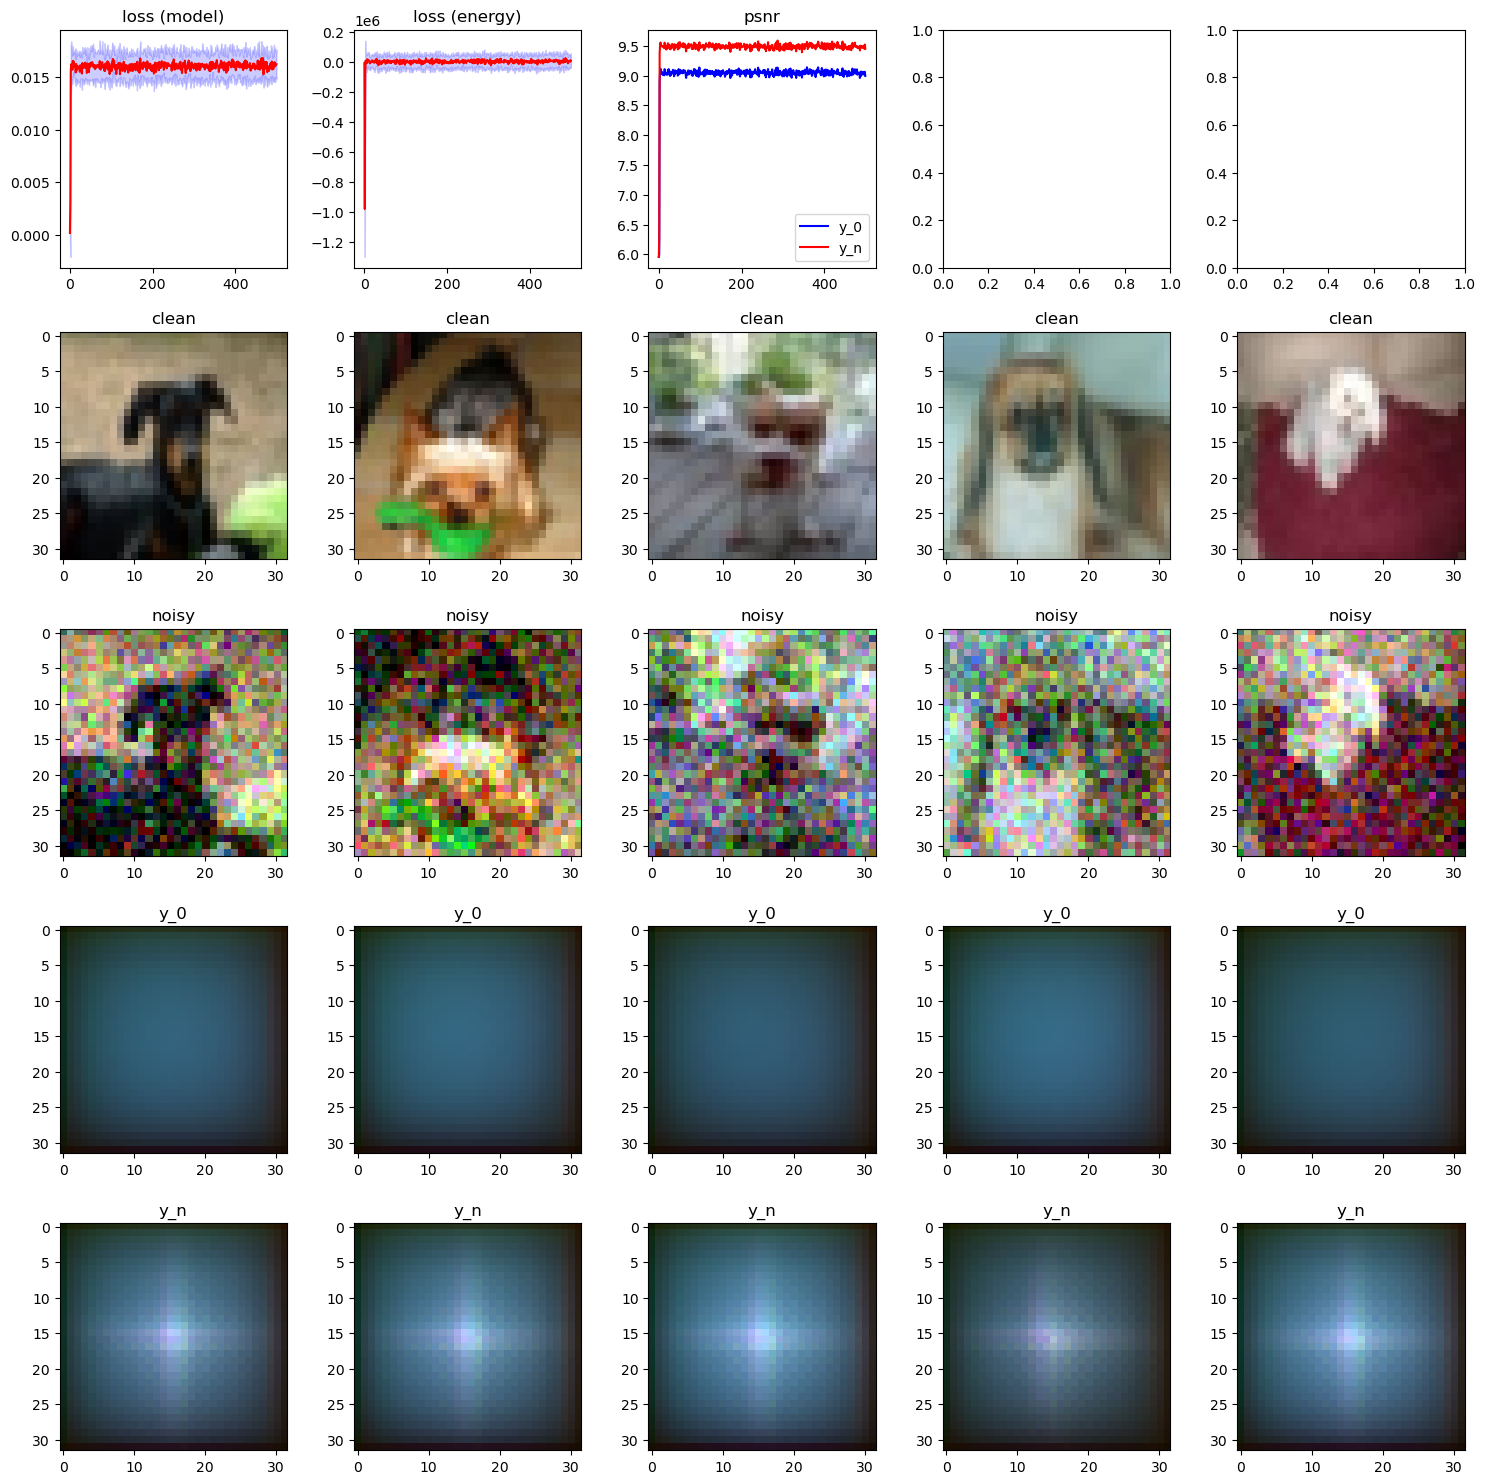

In [7]:
# -------------------------------------------------------------------
# save training results
# -------------------------------------------------------------------         
nRow    = 5 
nCol    = 5
fSize   = 3

fig, ax = plt.subplots(nRow, nCol, figsize=(fSize * nCol, fSize * nRow))

ax[0][0].set_title('loss (model)')
ax[0][0].plot(val_loss_model_mean, color='red')
ax[0][0].fill_between(list(range(optim_length_epoch)), val_loss_model_mean-val_loss_model_std, val_loss_model_mean+val_loss_model_std, color='blue', alpha=0.2)

ax[0][1].set_title('loss (energy)')
ax[0][1].plot(val_loss_energy_mean, color='red')
ax[0][1].fill_between(list(range(optim_length_epoch)), val_loss_energy_mean-val_loss_energy_std, val_loss_energy_mean+val_loss_energy_std, color='blue', alpha=0.2)

ax[0][2].set_title('psnr')
ax[0][2].plot(val_psnr_mean, color='blue', label='y_0')
ax[0][2].plot(val_psnr_update_mean, color='red', label='y_n')
ax[0][2].legend()

for i in range(nCol):
    ax[1][i].set_title('clean')
    ax[1][i].imshow(np.transpose(data[i], (1,2,0)))

for i in range(nCol):
    ax[2][i].set_title('noisy')
    ax[2][i].imshow(np.transpose(data_noise[i],(1,2,0)))

for i in range(nCol):
    ax[3][i].set_title('y_0')
    ax[3][i].imshow(np.transpose(pred[i],(1,2,0)))

for i in range(nCol):
    ax[4][i].set_title('y_n')
    ax[4][i].imshow(np.transpose(pred_update[i],(1,2,0)))

plt.tight_layout()
plt.show()
# fig.savefig(file_figure, bbox_inches='tight', dpi=300)
# plt.close(fig)